In [1]:
from itertools import islice
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
from the_well.data import WellDataset, WellDataModule
from walrus.data import MixedWellDataModule

from walrus_workshop import paths
from walrus_workshop.walrus import get_trajectory

# from walrus_workshop.viz import make_video
%matplotlib inline

In [41]:
from omegaconf import OmegaConf
walrus_config_file = paths.configs / "well_config.yaml"
walrus_config = OmegaConf.load(walrus_config_file)
config = walrus_config.data.module_parameters
print(config)

{'_target_': 'walrus.data.MixedWellDataModule', 'batch_size': 2, 'n_steps_input': 6, 'n_steps_output': 1, 'min_dt_stride': 1, 'max_dt_stride': 5, 'max_samples': 2000, 'well_dataset_info': {'rayleigh_benard': {'include_filters': [], 'exclude_filters': []}, 'shear_flow': {'include_filters': [], 'exclude_filters': []}, 'turbulent_radiative_layer_2D': {'include_filters': [], 'exclude_filters': []}}}


## MixedWellDataModule

In [2]:
datamodule = MixedWellDataModule(
    well_base_path=paths.well_base_path,
    batch_size=2,
    n_steps_input=6,
    n_steps_output=1,
    well_dataset_info={
        "shear_flow": {"include_filters": [], "exclude_filters": []}
        }
)
print(datamodule)
print(len(datamodule.train_dataset)) # Number of windows in the dataset

Failed to load acoustic_scattering_maze dataset
Failed to load acoustic_scattering_inclusions dataset
Failed to load acoustic_scattering_discontinuous dataset
Failed to load active_matter dataset
Failed to load convective_envelope_rsg dataset
Failed to load euler_multi_quadrants_openBC dataset
Failed to load euler_multi_quadrants_periodicBC dataset
Failed to load helmholtz_staircase dataset
Failed to load MHD_64 dataset
Failed to load MHD_256 dataset
Failed to load gray_scott_reaction_diffusion dataset
Failed to load planetswe dataset
Failed to load post_neutron_star_merger dataset
Failed to load rayleigh_benard_uniform dataset
Failed to load rayleigh_taylor_instability dataset


Failed to load supernova_explosion_64 dataset
Failed to load supernova_explosion_128 dataset
Failed to load turbulence_gravity_cooling dataset
Failed to load turbulent_radiative_layer_3D dataset
Failed to load viscoelastic_instability dataset


173824


In [29]:
def about_dataset(dataset):
    print(f"Number of windows (chunks of all simuations in the dataset): {len(dataset)}")
    # Take the first dataset
    window = dataset[0]
    metadata = window["metadata"]
    print(f"Number of files: {len(metadata.n_trajectories_per_file)}, number of trajectories total: {sum(metadata.n_trajectories_per_file)}")
    window_size = dataset.sub_dsets[0].n_steps_input + dataset.sub_dsets[0].n_steps_output
    # window_size = 6 + 1
    print(f"Window size: {window_size} time steps")
    print(f"Number of windows: {32 * sum([t - window_size + 1 for t in metadata.n_steps_per_trajectory])}")
    print(f"Number of windows over the entire dataset: {32 * 28 * (200 - window_size + 1)}")

about_dataset(datamodule.train_dataset)
print("\nTest:")
about_dataset(datamodule.test_datasets[0])

    # print([len(d) for d in datamodule.train_dataset])

Number of windows (chunks of all simuations in the dataset): 173824
Number of files: 28, number of trajectories total: 896
Window size: 7 time steps
Number of windows: 173824
Number of windows over the entire dataset: 173824

Test:
Number of windows (chunks of all simuations in the dataset): 21728
Number of files: 28, number of trajectories total: 112
Window size: 7 time steps
Number of windows: 173824
Number of windows over the entire dataset: 173824


Data shape:  torch.Size([1, 5, 1, 6, 256, 512])


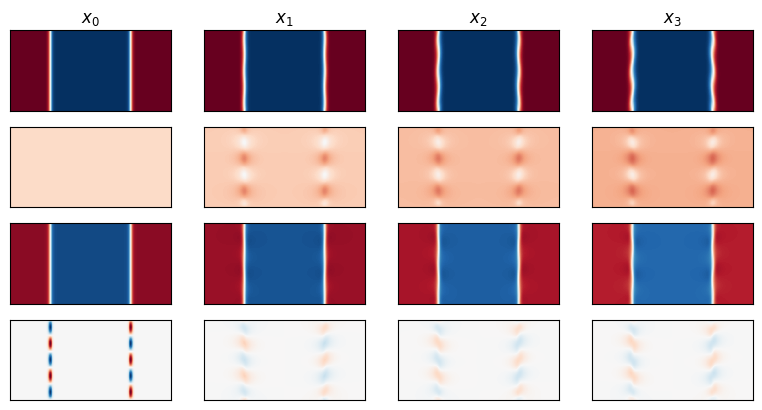

In [25]:
window = datamodule.train_dataset[0]
metadata = window["metadata"]
F = metadata.n_fields # Note that this has extra fields like velocity_z
# print(f"{F} field names: {dataset.metadata.field_names}")

B = 0 # But not actually the batch size...

fig, axs = plt.subplots(sum(window['padded_field_mask']).item(), 4, figsize=(4 * 2.4, sum(window['padded_field_mask']) * 1.2))

for t in range(4):
    window = datamodule.train_dataset[t]
    x = window["input_fields"] # B T Lx Ly Lz F
    x = rearrange(x, "B T ... Lz F -> B F Lz T ...") # B F Lz T Lx Ly
    for field in range(sum(window['padded_field_mask'])):
        vmin = np.nanmin(x[B, field])
        vmax = np.nanmax(x[B, field])
        axs[field, t].imshow(x[B, field, 0, 0], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
        axs[field, t].set_xticks([])
        axs[field, t].set_yticks([])

        axs[0, t].set_title(f"$x_{t}$")

print("Data shape: ", x.shape)

In [39]:
dataset = datamodule.rollout_train_datasets[0].sub_dsets[0] # BatchInflatedWellDataset
loader = datamodule.rollout_train_dataloaders()[0]

t = 50
dataset = next(
        islice(
            loader,
            t,
            t + 1,
        )
) # $$

Data shape:  torch.Size([1, 5, 1, 6, 256, 512])


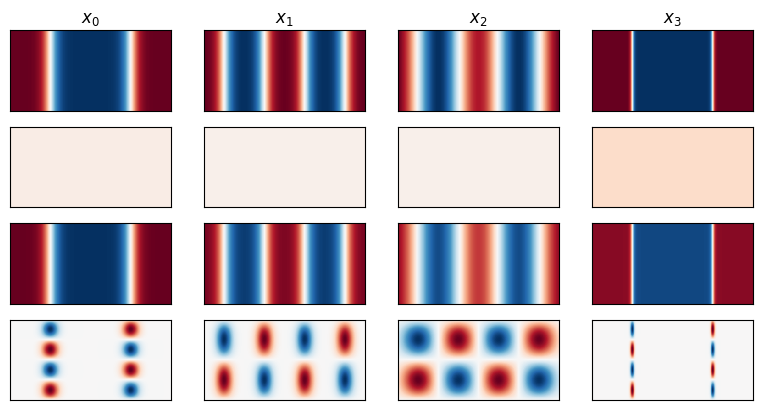

In [31]:
dataset = datamodule.rollout_train_datasets[0].sub_dsets[0] # BatchInflatedWellDataset
loader = datamodule.rollout_train_dataloaders()[0]
metadata = dataset.metadata
F = metadata.n_fields # Note that this has extra fields like velocity_z
# print(f"{F} field names: {dataset.metadata.field_names}")

B = 0 # But not actually the batch size...

fig, axs = plt.subplots(F := 4, 4, figsize=(4 * 2.4, F * 1.2))

for t in range(4):
    dataset = next(
            islice(
                loader,
                t,
                t + 1,
            )
    ) # $$
    x = dataset["input_fields"] # B T Lx Ly Lz F
    x = rearrange(x, "B T ... Lz F -> B F Lz T ...") # B F Lz T Lx Ly
    for field in range(sum(dataset['padded_field_mask'])):
        vmin = np.nanmin(x[B, field])
        vmax = np.nanmax(x[B, field])

        axs[field, t].imshow(x[B, field, 0, 0], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
        axs[field, t].set_xticks([])
        axs[field, t].set_yticks([])

        axs[0, t].set_title(f"$x_{t}$")

print("Data shape: ", x.shape)

## WellDataset

In [4]:
dataset = WellDataset(
    well_base_path=paths.well_base_path,
    well_dataset_name="shear_flow",
    well_split_name="train",
    n_steps_input=4,
    n_steps_output=1,
    use_normalization=False,
)

field_names = [
    name for group in dataset.metadata.field_names.values() for name in group
]
field_names
window_size = dataset.n_steps_input + dataset.n_steps_output

print(dataset[0].keys())
print(f"Number of files: {dataset.metadata.n_files}, Number of steps per trajectory: {dataset.metadata.n_steps_per_trajectory[0]}, Number of trajectories per file: {dataset.metadata.n_trajectories_per_file[0]}")
print(dataset.metadata.field_names)

window_size = dataset.n_steps_input + dataset.n_steps_output
total_windows = 0
for i in range(dataset.metadata.n_files):
    windows_per_trajectory = (
        dataset.metadata.n_steps_per_trajectory[i] - window_size + 1
    )
    total_windows += (
        windows_per_trajectory * dataset.metadata.n_trajectories_per_file[i]
    )

print(total_windows)
print(len(dataset))


dict_keys(['input_fields', 'output_fields', 'constant_scalars', 'boundary_conditions', 'space_grid', 'input_time_grid', 'output_time_grid'])
Number of files: 28, Number of steps per trajectory: 200, Number of trajectories per file: 32
{0: ['tracer', 'pressure'], 1: ['velocity_x', 'velocity_y'], 2: []}
175616
175616


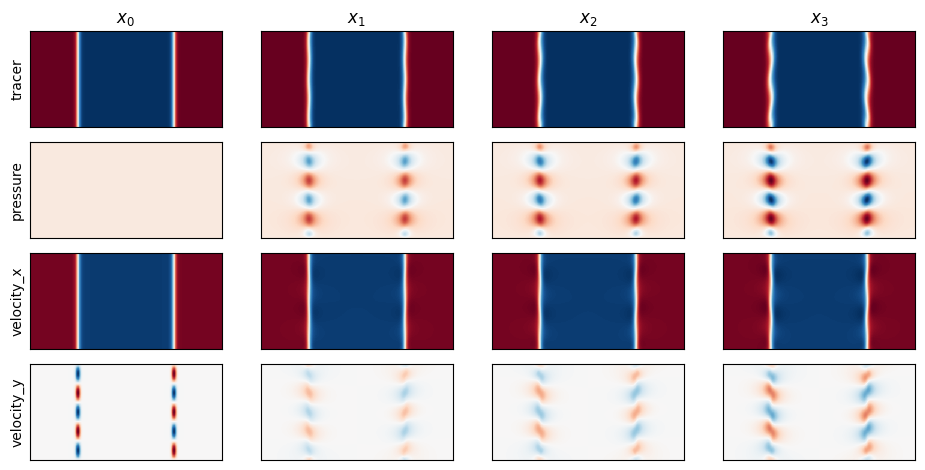

In [5]:
x = dataset[0]["input_fields"]
x = rearrange(x, "T Lx Ly F -> F T Lx Ly")
F = dataset.metadata.n_fields

fig, axs = plt.subplots(F, 4, figsize=(4 * 2.4, F * 1.2))

for field in range(F):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    axs[field, 0].set_ylabel(f"{field_names[field]}")

    for t in range(4):
        axs[field, t].imshow(
            x[field, t], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax
        )
        axs[field, t].set_xticks([])
        axs[field, t].set_yticks([])

        axs[0, t].set_title(f"$x_{t}$")

plt.tight_layout()

## WellDataModule

In [17]:
datamodule = WellDataModule(
    well_base_path=paths.well_base_path,
    well_dataset_name="shear_flow",
    batch_size=2
)
print(datamodule)
print(len(datamodule.train_dataset))

<WellDataModule: shear_flow on /home/krosenfeld/projects/walrus-workshop/data/datasets>
178304


Text(0.5, 0.98, 'DataSet via DataModule')

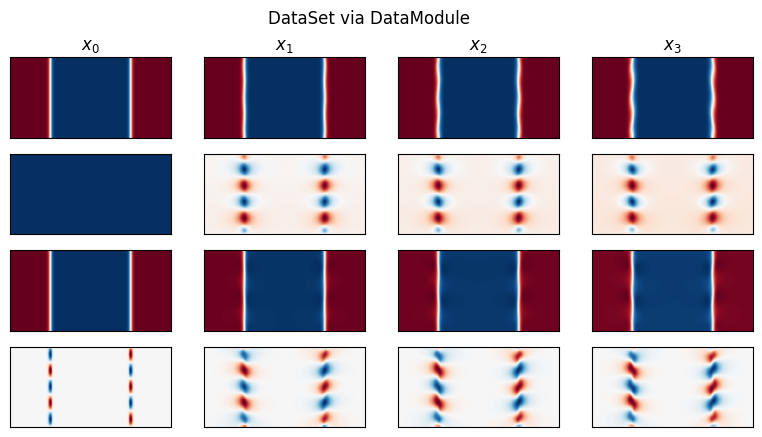

In [18]:
metadata = datamodule.train_dataset.metadata
F = metadata.n_fields

fig, axs = plt.subplots(F, 4, figsize=(4 * 2.4, F * 1.2))

for t in range(4):
    x = datamodule.train_dataset[t]["input_fields"]
    x = rearrange(x, "T Lx Ly F -> F T Lx Ly")
    for field in range(F):
        vmin = np.nanmin(x[field])
        vmax = np.nanmax(x[field])
        axs[field, t].imshow(x[field, 0], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
        axs[field, t].set_xticks([])
        axs[field, t].set_yticks([])

        axs[0, t].set_title(f"$x_{t}$")

fig.suptitle("DataSet via DataModule")

Text(0.5, 0.98, 'DataSet via DataModule Run 1')

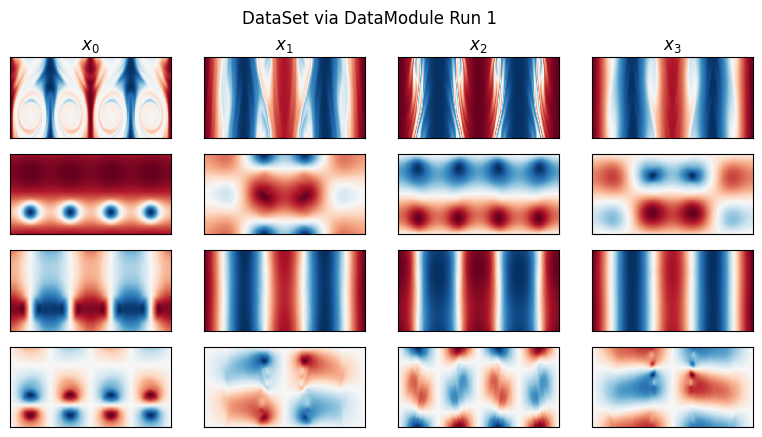

In [37]:
loader = datamodule.train_dataloader()
B = 0

for it in range(2): 

    fig, axs = plt.subplots(F, 4, figsize=(4 * 2.4, F * 1.2))

    for t, batch in enumerate(loader):
        if t > 3:
            break

        x = batch["input_fields"] # B T Lx Ly F
        x = rearrange(x, "B T Lx Ly F -> B F T Lx Ly")
        for field in range(F):
            vmin = np.nanmin(x[B, field])
            vmax = np.nanmax(x[B, field])
            axs[field, t].imshow(x[B, field, 0], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
            axs[field, t].set_xticks([])
            axs[field, t].set_yticks([])

            axs[0, t].set_title(f"$x_{t}$")

    fig.suptitle(f"DataSet via DataModule Run {it}")

## HDF5

In [17]:
import h5py
import glob
from walrus_workshop import paths

split = "test"
# file_list = glob.glob(str(paths.data / "datasets" / "shear_flow" / "data" / split / "*.hdf5"))
file_list = ['/home/krosenfeld/projects/walrus-workshop/data/datasets/shear_flow/data/test/shear_flow_Reynolds_1e4_Schmidt_2e0.hdf5']
print(f"Found {len(file_list)} files")
# for file in file_list:
#     print(file)

with h5py.File(file_list[0], "r") as f:
    print(f"Looking at {file_list[0]}")
    print(f.keys())
    print(f["dimensions"].keys())
    print(f["t0_fields"]['tracer'])

Found 1 files
Looking at /home/krosenfeld/projects/walrus-workshop/data/datasets/shear_flow/data/test/shear_flow_Reynolds_1e4_Schmidt_2e0.hdf5
<KeysViewHDF5 ['boundary_conditions', 'dimensions', 'scalars', 't0_fields', 't1_fields', 't2_fields']>
<KeysViewHDF5 ['time', 'x', 'y']>
<HDF5 dataset "tracer": shape (4, 200, 256, 512), type "<f4">
